In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
# Load the dataset
file_path = "/kaggle/input/iot-final-dataset/IotFinalDataset.csv"
df = pd.read_csv(file_path)

# Define target column
target_column = 'Label'

# Select features (excluding target)
features = [col for col in df.columns if col != target_column]

# Convert categorical labels to numerical values
label_encoder = LabelEncoder()
df[target_column] = label_encoder.fit_transform(df[target_column])

# Convert all features to numeric
df[features] = df[features].apply(pd.to_numeric, errors='coerce')

# Standardize numerical features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target_column], test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train, X_test = torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(X_test.values, dtype=torch.float32)
y_train, y_test = torch.tensor(y_train.values, dtype=torch.long), torch.tensor(y_test.values, dtype=torch.long)


In [3]:
class MLPClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # First hidden layer with 128 neurons
        self.relu = nn.ReLU()  # Activation function
        self.fc2 = nn.Linear(128, 64)  # Second hidden layer with 64 neurons
        self.fc3 = nn.Linear(64, num_classes)  # Output layer
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [4]:
# Model initialization
input_size = X_train.shape[1]
num_classes = len(np.unique(y_train))
model = MLPClassifier(input_size, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [5]:
epochs = 50  # Number of training iterations

for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    outputs = model(X_train)  # Forward pass
    loss = criterion(outputs, y_train)  # Compute loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [10/50], Loss: 2.0614
Epoch [20/50], Loss: 1.6253
Epoch [30/50], Loss: 1.1977
Epoch [40/50], Loss: 0.9564
Epoch [50/50], Loss: 0.8271


In [13]:
# Set model to evaluation mode
model.eval()

# Get predictions
with torch.no_grad():
    y_pred_logits = model(X_test)
    y_pred = y_pred_logits.argmax(dim=1)
    y_pred_proba = torch.nn.functional.softmax(y_pred_logits, dim=1).numpy()

# Convert tensors to NumPy arrays
y_test_np = y_test.numpy()
y_pred_np = y_pred.numpy()


In [14]:
accuracy = accuracy_score(y_test_np, y_pred_np)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.7747


In [15]:
print("\nClassification Report:")
print(classification_report(y_test_np, y_pred_np, target_names=label_encoder.classes_))



Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                    precision    recall  f1-score   support

            Benign       0.74      0.94      0.83     65391
         DNS Flood       0.00      0.00      0.00      9338
 Dictionary Attack       0.00      0.00      0.00      2013
        ICMP Flood       0.96      1.00      0.98     44930
           OS Scan       0.00      0.00      0.00      7700
        Ping Sweep       0.00      0.00      0.00     14358
         Port Scan       0.73      0.97      0.83     88162
         SYN Flood       0.00      0.00      0.00      2817
         Slowloris       0.00      0.00      0.00      3724
         UDP Flood       0.00      0.00      0.00      2015
Vulnerability Scan       0.00      0.00      0.00      8015

          accuracy                           0.77    248463
         macro avg       0.22      0.27      0.24    248463
      weighted avg       0.63      0.77      0.69    248463



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


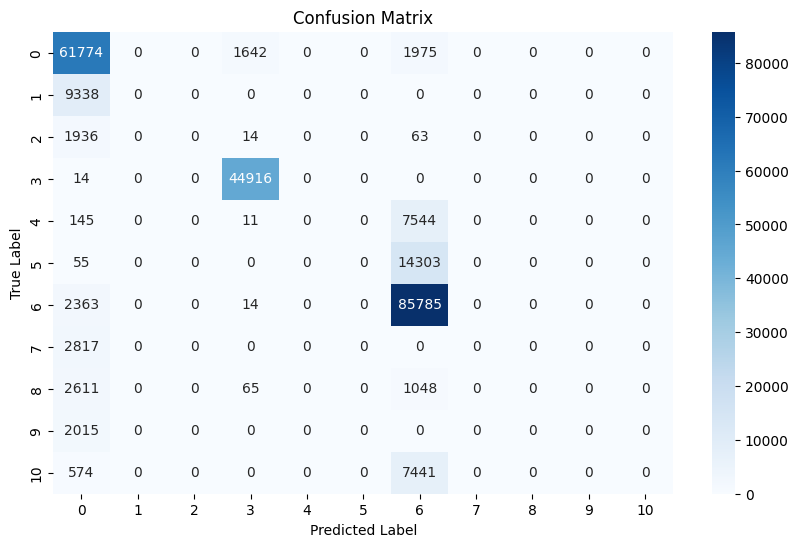

In [16]:
conf_matrix = confusion_matrix(y_test_np, y_pred_np)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test_np), yticklabels=np.unique(y_test_np))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [17]:
log_loss_value = log_loss(y_test_np, y_pred_proba)
print(f"Log Loss: {log_loss_value:.4f}")


Log Loss: 0.8211


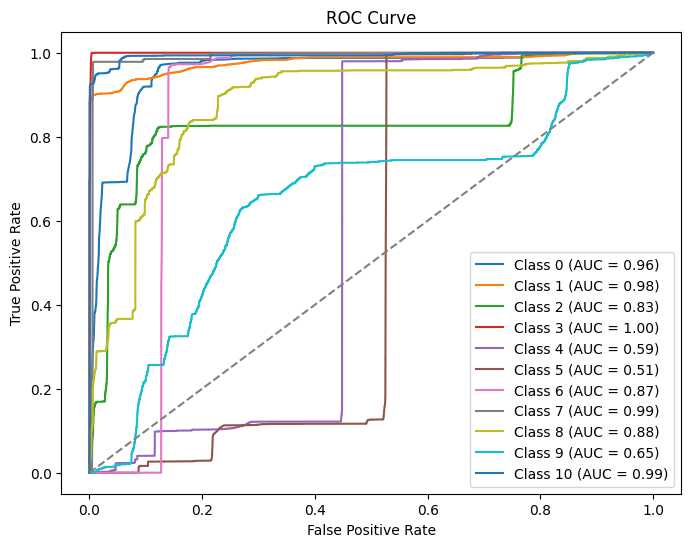

In [18]:
from sklearn.preprocessing import label_binarize

# Binarize the output labels for multi-class
y_test_bin = label_binarize(y_test_np, classes=np.unique(y_test_np))

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


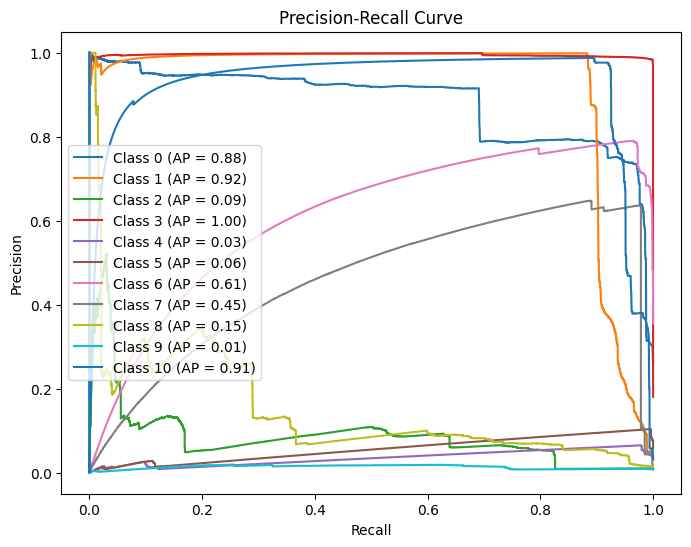

In [19]:
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
    ap_score = average_precision_score(y_test_bin[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, label=f'Class {i} (AP = {ap_score:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


In [20]:
torch.save(model.state_dict(), "mlp_model.pth")
joblib.dump(scaler, "scaler.pkl")
print("Model and scaler saved successfully!")


Model and scaler saved successfully!
